## Import libraries

In [17]:
import matplotlib.pyplot as plt         # for plotting
import numpy as np                      # for math

from IPython.display import HTML        # for displaying animation inside the notebook
import matplotlib.animation as ani      # for generating the animation

import matplotlib.cm as cm              # for creating color maps
# from matplotlib.colors import Normalize 

import scipy.optimize as opt

## Solving the non-reciprocal XY model on a triangular lattice with PBC

$\vec{a}_1$ and $\vec{a}_2$ are the lattice vectors of unit length (nearest neighbor spacing $a$ is taken as 1) for a triangular lattice. $\vec{a}_1 = \hat{x}$ and $\vec{a}_2 = \cos \frac{\pi}{3} \hat{x} + \sin \frac{\pi}{3} \hat{y}$. 

In [18]:
a1=np.array([1,0])
a2=np.array([0.5,np.sqrt(3)/2])

$n_1$ is the number of sites along the width of the parallelogram and $n_2$ is the number of sites along its height.

In [19]:
n1=100
n2=100

$X$ and $Y$ are vectors of all the $x$ and $y$ locations of each site. The index of the vector is the index of the site, which increases first in columns from left to right and then by rows from bottom to top. So, the bottom left corner is site 0 and the top left corner is site $n_1n_2-1$.

In [4]:
x1=np.arange(n1)*a1[0]    # possible x components from lattice vector a1
x2=np.arange(n2)*a2[0]    # possible x components from lattice vector a2
xOut=np.add.outer(x2,x1)  # take the "outer product" using addition instead of multiplication
X=xOut.flatten()          # flatten the list to obtain all possible x coordinates

y1=np.arange(n1)*a1[1]    # same for y
y2=np.arange(n2)*a2[1]
yOut=np.add.outer(y2,y1)
Y=yOut.flatten()

Define an initial condition (a list of values for each site). Note that if we interpret these values as angles of rotation $\theta$, we enforce uniaxial symmetry by taking the modulus of each value with $\pi$.

In [5]:
thTest=np.sqrt(X**2+Y**2)%np.pi 

A color plot is used.

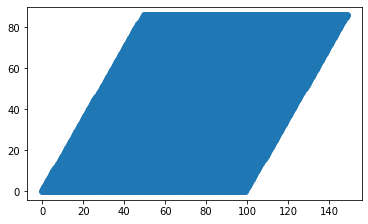

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(X,Y)#,c=thTest,cmap="hsv")
plt.gca().set_aspect('equal')

The unit cell is a site with three bonds each separated by angle $\frac{\pi}{3}$. The horizontal bond to the right of the site is included as bond 1. Progressing ccw we have bonds 2 then 3. Here we define the difference matrices $D1,D2,D3$ used to compare flow across each of the three bonds. We take the flow of $\theta$ to be positive if it is leaving the site, so all matrices must have $-1$'s along their diagonals. The other values in the $D$ matrices are filled in while enforcing periodic boundary conditions.

In [7]:
D1=-np.identity(n1*n2)
D2=-np.identity(n1*n2)
D3=-np.identity(n1*n2)

for i in np.arange(n1):
    for j in np.arange(n2):
        
        # Each site is indexed by j*n1+i
        ind=j*n1+i                    
        
        # The neighboring site connected by bond 1 is in the same row and the right-adjacent column. 
        # But when the adjacent column exceeds the width of the lattice, wrap around to the 0th column for PBC.
        indD1= j*n1+(i+1)%n1
        
        # The neighboring site connected by bond 2 is in the above-adjacent row and left-adjacent column.
        # But when the column is 
        indD2= n1*((j+1)%n2)+(i-1)%n1
        
        #The neighboring site connected by bond 3 is in the same column and the bottom-adjacent row.
        # But when the row is already at the bottom, wrap around to the top row
        indD3= n1*((j-1)%n2)+i%n1
        D1[ind,indD1]=1
        D2[ind,indD2]=1
        D3[ind,indD3]=1

$g^e$ and $g^o$ are the coupling strengths of the even and odd types of exchange of $\theta$. 

In [8]:
ge=1
go=0

This function takes in $\vec{\theta}$ at a particular timestep and returns the vector of "torques" $\vec{\tau}$.

In [9]:
def getTau(thVals):
    d1=D1.dot(thVals)    # calculate the differences in each direction
    d2=D2.dot(thVals)          
    d3=D3.dot(thVals)
    
    d1f=np.sin(2*d1)     # this quantity is preferred to d1 because it enforces uniaxiality. 
    d2f=np.sin(2*d2)     # since sine is monotonic to pi/2, it works just as well as taking the difference
    d3f=np.sin(2*d3)     # while physics would occur at a different rate than if it was not sin, the physics
                         # is qualitatively unchanged
    
    J1 = ge*d1f + go*(d2f-d3f)/2   # calculate the "angular momentum" currents 
    J2 = ge*d2f + go*(d3f-d1f)/2
    J3 = ge*d3f + go*(d1f-d2f)/2
    
    # the "torque" felt at each site is a linear combination of the discrete derivatives (differences) of each J
    tau = -D1.transpose().dot(J1) - D2.transpose().dot(J2) - D3.transpose().dot(J3)
    
    return tau

This cell solves the damped equation of motion $\dot{\vec{\theta}} = H \vec{\theta}$ numerically. The data is contained in thData.

In [10]:
tf=10     # maximum step
dt=0.1    # step size
t=0       # minimum step

th=(np.pi*X/(np.max(X)-np.min(X)))%np.pi   # the initial condition
#th=np.zeros_like(Y)

thData=th.copy()

# the ODE solver algorithm
while t < tf:
    thH = th + 0.5*dt*getTau(th)
    th=(th+dt*getTau(thH))%np.pi
    thData=np.vstack((thData,th))   # the list of thetas at each timestep is stored as a vector in thData
    t+=dt

Plot the initial state as a color plot if desired.

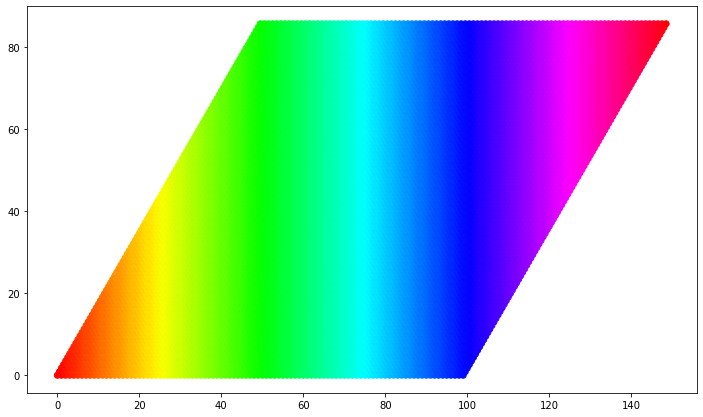

In [11]:
plt.figure(figsize=(12,12))
plt.scatter(X,Y,c=thData[0,:],cmap="hsv")
plt.gca().set_aspect("equal")
#plt.close()

# Animating

By stringing together scatter plots of thData at each (or regular) timesteps, we can animate how the system evolves in time. First we create a quiver plot of the initial state.

In [12]:
fig, ax = plt.subplots()        # create a figure fig with a single subplot ax
clist=cm.hsv(thData[0,:]/np.pi) # create a cyclic color map (should range from 0 to 1 so divide data by pi)

# we display each rod as a headless arrow in a Python quiver plot
# including both a cyclic color scheme in pi and displaying the points as rods is redundant but visually useful
quiv=ax.quiver(X, Y, np.cos(thData[0,:]), np.sin(thData[0,:]),
               pivot="mid", scale=40, headlength=0, headwidth=1,
               color=clist)

fig.set_figwidth(12)     # sets the size of the figure (the object which contains the subplot)
fig.set_figheight(6)

ax.set_aspect("equal")   # let one unit on the y-axis be graphically equal to one unit on the x-axis
ax.axis("off")           # disable axes

plt.close(fig)           # toggle whether or not the figure is displayed

# define a function that updates the quiver plot at the indth timestep
def update_plot(ind):
    U=np.cos(thData[ind,:])             # recalculate the head x-components          
    V=np.sin(thData[ind,:])             # recalculate the head y-components
    clist=cm.hsv((thData[ind,:])/np.pi) # update the color list ensuring it remains properly normalized 
    quiv.set_color(clist)               # update the colors on the subplot
    quiv.set_UVC(U,V)                   # update rod orientations on the subplot
    return quiv

Use the update_plot function as an argument of the stringing-together function FuncAnimation to animate the data into a movie.

In [20]:
datalen=thData.shape[0]                       # the number of timesteps taken over the course of the routine

aniTest=ani.FuncAnimation(fig,                # we want to animate the figure
                          update_plot,        # by applying update_plot
                          np.arange(datalen), # at each timestep of thData
                          interval=50,        # this is the delay between frames in ms
                          blit=False)         # an image processing setting

HTML(aniTest.to_html5_video())                # display the animation in the browser

# aniTest.save("test.mp4")                    # save the resulting animation if desired

/home/shae/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


## Free boundary conditions

Define mask1, a true/false vector, which will determine the outer boundary of the region of interest. Applying this mask to the vectors of $x$ and $y$ coordinates ($X$ and $Y$) yields new vectors $\tilde{X}$ and $\tilde{Y}$ which keep each entry that corresponds to a True in the mask and removes each entry which corresponds to a False. By setting our mask to be a condition imposed on $X$ and $Y$, we can obtain the coordinates of the sites where that condition is true.

In [21]:
mask1=np.sqrt((X-np.average(X))**2+(Y-np.average(Y))**2)<20   # choose a centered circular region
Xt=X[mask1]
Yt=Y[mask1]

Let's look at the sites kept by the mask (blue) on a graph of the total sites (grey).

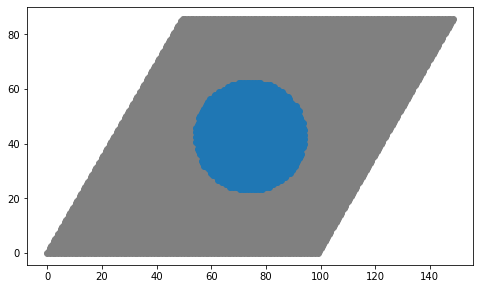

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(X,Y,c="grey")
plt.scatter(Xt,Yt)
plt.gca().set_aspect("equal")

What are the difference matrices for the sites in this new region? All bonds (rows) and sites (columns) associated with each excluded site should be eliminated. So, we apply the mask on each row and column of each difference matrix to obtain $\tilde{D1},\tilde{D2},\tilde{D3}$.

In [23]:
D1t=D1[mask1][:,mask1]
D2t=D2[mask1][:,mask1]
D3t=D3[mask1][:,mask1]

However we are not done. We must treat the sites on the boundary carefully. The flow out of any site on a boundary will be zero, while the flow in may be nonzero. Consider the sum across the rows of the difference matrices. If the sum is 0, then the sites tied together by that row are within the bulk of the region. If the sum is negative, there is a dangling bond. The site associated with this dangling bond should be eliminated from the difference matrix since there is no flow. A row that sums to 1 has an outflow but not an inflow, which is fine for free boundary conditions.

In [24]:
inds1=np.where(D1t.sum(axis=1)<0)[0]  # collect the indicies of the dangling bonds
inds2=np.where(D2t.sum(axis=1)<0)[0]
inds3=np.where(D3t.sum(axis=1)<0)[0]

D1t[inds1,:]=0 # eliminate the sites corresponding to those indicies from the difference matrices
D2t[inds2,:]=0
D3t[inds3,:]=0

Here we modify the getTau function to obtain getTauB. They do the same thing, but here we only consider the sites in the region denoted by mask1, so the difference matrices should be replace with their tilde equivalents.  

In [25]:
ge=1
go=1

def getTauB(thVals):
    d1=D1t.dot(thVals)    # calculate the differences in each direction
    d2=D2t.dot(thVals)          
    d3=D3t.dot(thVals)
    
    d1f=np.sin(2*d1)     # this quantity is preferred to d1 because it enforces uniaxiality. 
    d2f=np.sin(2*d2)     # since sine is monotonic to pi/2, it works just as well as taking the difference
    d3f=np.sin(2*d3)     # while physics would occur at a different rate than if it was not sin, the physics
                         # is qualitatively unchanged
    
    J1 = ge*d1f + go*(d2f-d3f)/2   # calculate the "angular momentum" currents 
    J2 = ge*d2f + go*(d3f-d1f)/2
    J3 = ge*d3f + go*(d1f-d2f)/2
    
    # the "torque" felt at each site is a linear combination of the discrete derivatives (differences) of each J
    tau = -D1t.transpose().dot(J1) - D2t.transpose().dot(J2) - D3t.transpose().dot(J3)
    
    return tau

We again solve the ODE but now only in the region marked by mask1, and data is now only recorded every so often according to pt.

In [29]:
%%time

tf=50      # maximum step
dt=0.05    # step size
pt=0.1     # the constant which determines how frequently to actually store the data in thDataB
t=0        # minimum step
tprint=0   # initializes the variable used to determine when to store data

# decide on an initial condition. Here we have two separated defects
dist=7

# xdisc=np.average(Xt)-dist/2
# ydisc=np.average(Yt)

# xdisc2=np.average(Xt)+dist/2
# ydisc2=np.average(Yt)

# th=(np.arctan2(Yt-ydisc,Xt-xdisc)/2-np.arctan2(Yt-ydisc2,Xt-xdisc2)/2)%np.pi

th=(np.arctan2(Yt-np.average(Yt),Xt-np.average(Xt)-15)/2)%np.pi

#th=np.pi*(Xt-np.min(Xt))/(np.max(Xt)-np.min(Xt))

thDataB=th.copy()
# the ODE solver algorithm
while t < tf:
    thH = th + 0.5*dt*getTauB(th)
    th=(th+dt*getTauB(thH))%np.pi
    if t > tprint:
        thDataB=np.vstack((thDataB,th))   # the list of theta's at each timestep is stored as a vector in thData
        tprint+=pt
    t+=dt

CPU times: user 1min 31s, sys: 228 ms, total: 1min 31s
Wall time: 15.3 s


Same plotting/plot update routine as before except now we are using thDataB instead of thData.

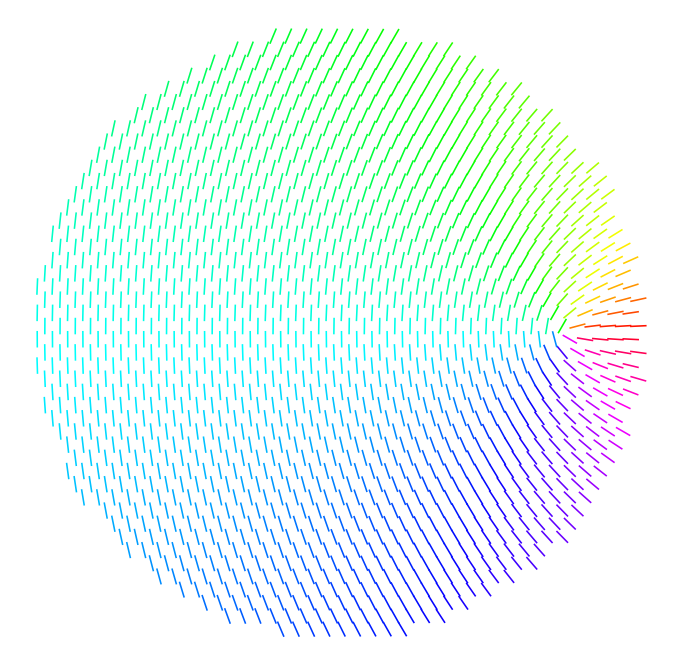

In [30]:
fig, ax = plt.subplots()

clist=cm.hsv(thDataB[0,:]/np.pi)

quiv=ax.quiver(Xt, Yt, np.cos(thDataB[0,:]), np.sin(thDataB[0,:]),
               pivot="mid", scale=40, headlength=0, headwidth=1,
              color=clist,zorder=1)

# ax.scatter(X,Y,c='grey',zorder=0)

fig.set_figwidth(12)
fig.set_figheight(12)

ax.set_aspect("equal")
ax.axis("off")

# plt.close(fig)

def update_plot(ind):
    U=np.cos(thDataB[ind,:])
    V=np.sin(thDataB[ind,:])
    clist=cm.hsv(thDataB[ind,:]/np.pi)
    quiv.set_color(clist)
    quiv.set_UVC(U,V)
    return quiv

Same animation code as before except now we use thDataB instead of thData.

In [31]:
datalen=thDataB.shape[0]                      # the number of timesteps taken over the course of the routine

aniTest=ani.FuncAnimation(fig,                # we want to animate the figure
                          update_plot,        # by applying update_plot
                          np.arange(datalen), # at each timestep of thData
                          interval=50,        # this is the delay between frames in ms
                          blit=False)         # an image processing setting

HTML(aniTest.to_html5_video())                # display the animation in the browser

# aniTest.save("test.mp4")                    # save the resulting animation if desired

## Free Boundary Analysis

In [33]:
def Cgrain(xp,yp,xv,yv,thv,sigma=2.0):
    edata=np.exp(2j*thv)
    
    dx=np.add.outer(xp,-xv)
    dy=np.add.outer(yp,-yv)
    gmat=np.exp(-(dx**2+dy**2)/(2*sigma**2))
    Norm=gmat.sum(axis=1)
    
    fav=(1/Norm)*gmat.dot(edata)
    return fav

### Off center particle

In [34]:
xthree=np.linspace(np.min(Xt),np.max(Xt),50)
ythree=np.average(Yt)*np.ones_like(xthree)
datatwo=thDataB[-1,:]

In [35]:
rad=15

phivals=np.linspace(0,2*np.pi,40)

xfour=np.average(Xt)+rad*np.cos(phivals)
yfour=np.average(Yt)+rad*np.sin(phivals)

In [36]:
smooth3=Cgrain(xthree,ythree,Xt,Yt,datatwo)
smooth4=Cgrain(xfour,yfour,Xt,Yt,datatwo)

In [37]:
def theory_shell(xoff,xv,yv,RR=20,s=0.5):
    xmirror=RR**2/xoff
    phivals1=np.arctan2(yv,xv-xoff)
    phivals2=np.arctan2(yv,xv-xmirror)
    
    rvals1=np.sqrt((xv-xoff)**2+yv**2)
    rvals2=np.sqrt((xv-xmirror)**2+yv**2)
    
    thvals1=s*phivals1-s*(go/ge)*np.log(rvals1)
    thvals2=s*phivals2-s*(go/ge)*np.log(rvals2)
    
    thtot=(thvals1-thvals2)%np.pi
    return thtot

In [38]:
#theoryPhitest=theory_shell(10,xfour-np.average(Xt),yfour-np.average(Yt))
theoryPhi=theory_shell(10,xfour-np.average(Xt),yfour-np.average(Yt))

(-0.05, 1.05)

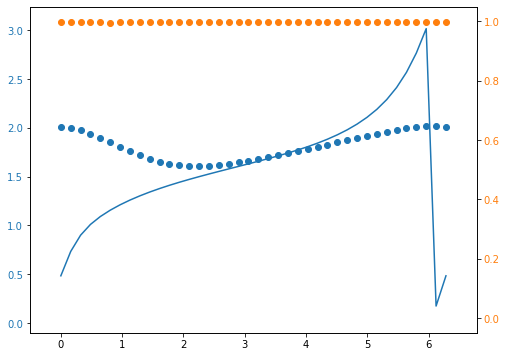

In [39]:
figPhi2,ax1=plt.subplots()

ax2=ax1.twinx()

ax2.scatter(phivals,np.abs(smooth4),color="C1",zorder=0)

ax1.scatter(phivals,(np.angle(smooth4)/2+0.2)%np.pi,zorder=1)

ax1.plot(phivals,(theoryPhi+1.25)%np.pi,zorder=1)

#ax1.plot(phivals,(theoryPhitest+1.25)%np.pi,zorder=1)

#ax1.plot(xone[1:]-xone[0],-0.5*(go/ge)*np.log(xone[1:]-xone[0])+1.29,zorder=1)

#ax1.axvline(0.5,c="grey",ls="dashed")
#ax1.axvline(5.5,c="grey",ls="dashed")

#ax1.fill_betweenx([-2,4],[4,4],[16,16],zorder=0,color="lightgray")

ax2.tick_params(axis='y',labelcolor="C1")
ax1.tick_params(axis="y",labelcolor="C0")


figPhi2.set_figwidth(8)
figPhi2.set_figheight(6)

ax2.set_xlim((0-0.5,2*np.pi+0.5))
ax1.set_ylim((-0.1,np.pi+0.1))
ax2.set_ylim((-0.05,1.05))

In [40]:
#figPhi2.savefig(outfolder+"Offset10.pdf")

In [41]:
theoryRad=theory_shell(10,xthree-np.average(Xt),ythree-np.average(Yt))

(-0.05, 1.05)

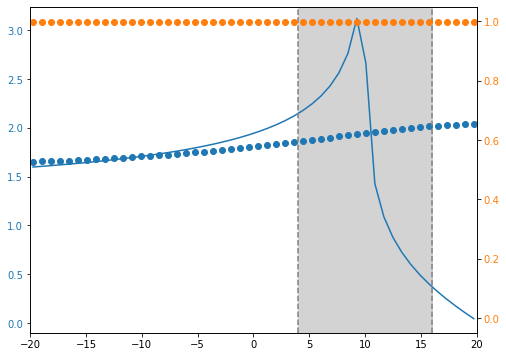

In [42]:
figRad2,ax1=plt.subplots()

ax2=ax1.twinx()

ax2.scatter(xthree-np.average(Xt),np.abs(smooth3),color="C1",zorder=0)

ax1.scatter(xthree-np.average(Xt),(np.angle(smooth3)/2+0.2)%np.pi,zorder=1)

ax1.plot(xthree-np.average(Xt),(theoryRad+1.25)%np.pi,zorder=1)

#ax1.plot(xone[1:]-xone[0],-0.5*(go/ge)*np.log(xone[1:]-xone[0])+1.29,zorder=1)


ax1.axvline(4.0,c="grey",ls="dashed")
ax1.axvline(16.0,c="grey",ls="dashed")

ax1.fill_betweenx([-2,4],[4,4],[16,16],zorder=0,color="lightgray")

ax2.tick_params(axis='y',labelcolor="C1")
ax1.tick_params(axis="y",labelcolor="C0")


figRad2.set_figwidth(8)
figRad2.set_figheight(6)

ax2.set_xlim((-20,20))
ax1.set_ylim((-0.1,np.pi+0.1))
ax2.set_ylim((-0.05,1.05))

In [43]:
#figRad2.savefig(outfolder+"Offset10Radial.pdf")

In [44]:
### Centered Particle

In [45]:
np.max(Xt)

94.0

In [46]:
xone=np.linspace(np.average(Xt),np.max(Xt),20)
yone=np.average(Yt)*np.ones_like(xone)
dataone=thDataB[-1,:]

In [47]:
rad=15

phivals=np.linspace(0,2*np.pi,20)

xtwo=np.average(Xt)+rad*np.cos(phivals)
ytwo=np.average(Yt)+rad*np.sin(phivals)

In [48]:
smooth1=Cgrain(xone,yone,Xt,Yt,dataone)
smooth2=Cgrain(xtwo,ytwo,Xt,Yt,dataone)

(-0.05, 1.05)

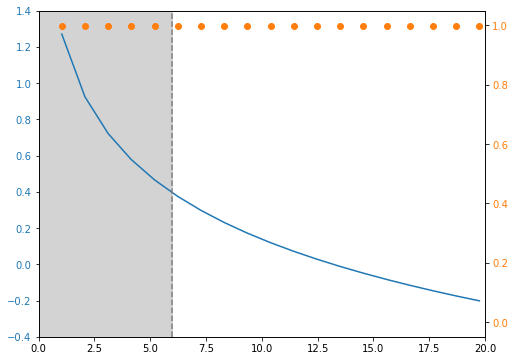

In [49]:
#plt.figure(figsize=(8,6))

go=1
ge=1

figRad1,ax1=plt.subplots()

ax2=ax1.twinx()

ax2.scatter(xone[1:]-xone[0],np.abs(smooth1[1:]),color="C1",zorder=0)

ax1.scatter(xone[1:]-xone[0],(np.angle(smooth1[1:])/2),zorder=1)

ax1.plot(xone[1:]-xone[0],(-0.5*(go/ge)*np.log(xone[1:]-xone[0])+1.29),zorder=1)


ax1.axvline(6.0,c="grey",ls="dashed")

ax1.fill_betweenx([-2,2],[0,0],[6.0,6.0],zorder=0,color="lightgray")

ax2.tick_params(axis='y',labelcolor="C1")
ax1.tick_params(axis="y",labelcolor="C0")


figRad1.set_figwidth(8)
figRad1.set_figheight(6)

ax2.set_xlim((0,20))
ax1.set_ylim((-0.4,1.4))
ax2.set_ylim((-0.05,1.05))

In [50]:
#outfolder="/Users/ColinS/Documents/Research/NematicElasticity/Figures/Numerics12_14/"

In [51]:
#figRad1.savefig(outfolder+"Radial_Data1.pdf")

In [52]:
#plt.scatter(np.log(xone[1:]-xone[0]),np.log(-np.log(np.abs(smooth1[1:]))))

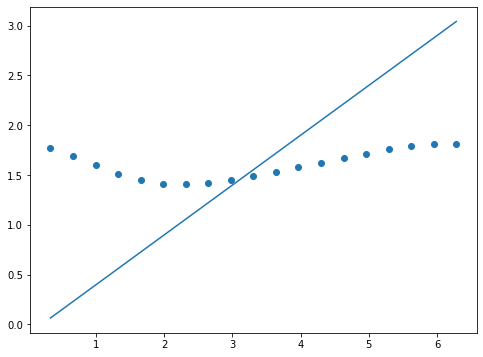

In [53]:
figPhi1,ax1=plt.subplots()

ax1.scatter(phivals[1:],(np.angle(smooth2[1:])/2)%np.pi,zorder=1)

ax1.plot(phivals[1:],(np.angle(np.exp(1j*phivals[1:]))/2-0.1)%np.pi,zorder=1)


figPhi1.set_figwidth(8)
figPhi1.set_figheight(6)

In [54]:
#figPhi1.savefig(outfolder+"Phi_Data1.pdf")

(52.525, 95.975, 21.434128743664854, 64.30238623099456)

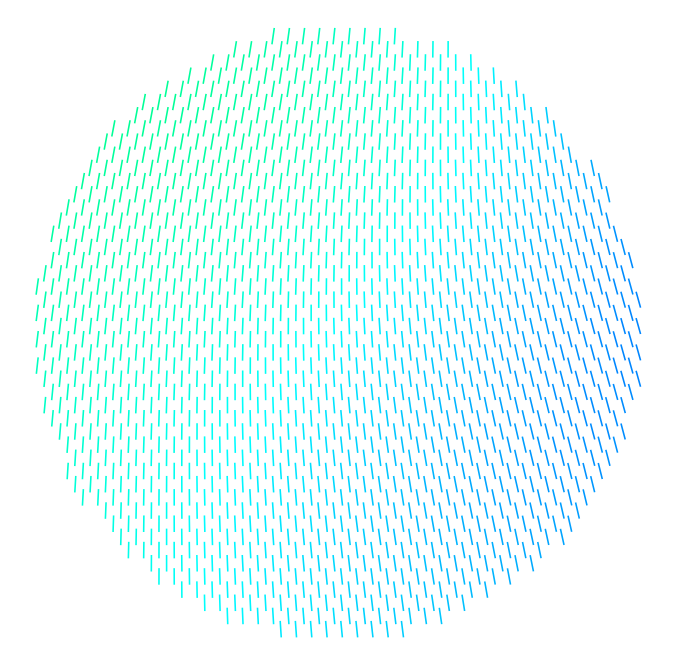

In [55]:
fig, ax = plt.subplots()

clist=cm.hsv(thDataB[-1,:]/np.pi)

quiv=ax.quiver(Xt,Yt,np.cos(dataone),np.sin(dataone),scale=40, pivot="mid", headlength=0, headwidth=1, color=clist, zorder=1)

# ax.scatter(xone,yone,c='grey',zorder=0)
# ax.scatter(xtwo,ytwo,c="grey",zorder=0)


fig.set_figwidth(12)
fig.set_figheight(12)

ax.set_aspect("equal")
ax.axis("off")

## Multiple, fixed boundaries

Consider now specifying two regions using two masks.

In [56]:
mask1=np.sqrt((X-np.average(X))**2+(Y-np.average(Y))**2)<20
mask2=np.sqrt((X-np.average(X))**2+(Y-np.average(Y))**2)<2
Xt=X[mask1]
Yt=Y[mask1]

Again define the difference matrices for the sites encompassed only by mask 1.

In [57]:
D1t=D1[mask1][:,mask1]
D2t=D2[mask1][:,mask1]
D3t=D3[mask1][:,mask1]

inds1=np.where(D1t.sum(axis=1)<0)[0]
inds2=np.where(D2t.sum(axis=1)<0)[0]
inds3=np.where(D3t.sum(axis=1)<0)[0]

D1t[inds1,:]=0
D2t[inds2,:]=0
D3t[inds3,:]=0

Here we identify the sites that lie on the boundaries of mask1 and call the array bindst.

In [58]:
'''
the ith element of b1 provides information about the ith site depending on its value as follows
(1) 0: the site does not contribute to a net flow across the mask1 boundary (this could be a boundary site)
(2) 1: the site has a flow into the mask1 region but not out of it (it lies right outside)
(3) -1: the site has a flow out of the mask1 region but not into it (it lies right inside) 
we calculate such a vector for all 3 bond directions
'''
b1=D1.dot(mask1)                    
b2=D2.dot(mask1)  
b3=D3.dot(mask1)

'''
the ith element of p1 provides information about the ith site depending on its value as follows
(1) 1,2: the site lies in the mask1 region on the boundary
(2) -1,-2: the site lies outside the mask1 region next to the boundary
(3) 0: the site is either interior to mask1 or exterior and not adjacent to the boundary
taking the transpose of the difference matrices puts information about the sites on the rows
'''
p1=D1.transpose().dot(b1) 
p2=D2.transpose().dot(b2)
p3=D3.transpose().dot(b3)

# vectors with True's for the sites that lie on the boundary for each of the three directions 
bool1=p1>0
bool2=p2>0
bool3=p3>0

booltot=bool1+bool2+bool3           # use logical "or" to convey indicate being outside boundary in any direction 

binds=np.where(booltot)[0]          # the absolute site indicies which lie on the boundary
bindst=np.where(booltot[mask1])[0]  # the site indicies which lie on the boundary as measured on the mask1 region

Perform same procedure but for the other boundary.

In [59]:
b1=D1.dot(mask2)
b2=D2.dot(mask2)
b3=D3.dot(mask2)

p1=D1.transpose().dot(b1)
p2=D2.transpose().dot(b2)
p3=D3.transpose().dot(b3)

bool1=p1>0
bool2=p2>0
bool3=p3>0

booltot=bool1+bool2+bool3

bindst2=np.where(booltot[mask1])[0] 

Let's look at the sites kept by mask1 (blue) on a graph of the total sites (grey), with the boundary of mask1 and mask2 highlighted in red and orange respectively.

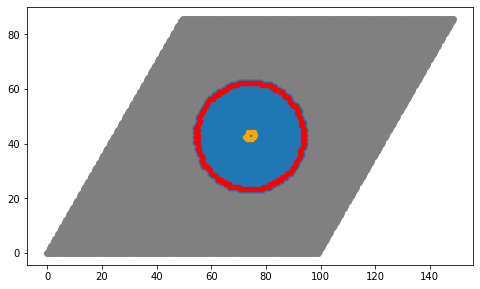

In [60]:
plt.figure(figsize=(8,8))
plt.scatter(X,Y,c="grey")
plt.scatter(Xt,Yt,s=50)
plt.scatter(Xt[bindst],Yt[bindst],c="red",s=20)
plt.scatter(Xt[bindst2],Yt[bindst2],c="orange",s=20)
plt.gca().set_aspect("equal")

In [61]:
ge=1
go=0

def getTauB(thVals):
    d1=D1t.dot(thVals)    # calculate the differences in each direction
    d2=D2t.dot(thVals)          
    d3=D3t.dot(thVals)
    
    d1f=np.sin(2*d1)     # this quantity is preferred to d1 because it enforces uniaxiality 
    d2f=np.sin(2*d2)
    d3f=np.sin(2*d3)
    
    J1 = ge*d1f + go*(d2f-d3f)/2   # calculate the "angular momentum" currents 
    J2 = ge*d2f + go*(d3f-d1f)/2
    J3 = ge*d3f + go*(d1f-d2f)/2
    
    # the "torque" felt at each site is a linear combination of the discrete derivatives (differences) of each J
    tau = -D1t.transpose().dot(J1) - D2t.transpose().dot(J2) - D3t.transpose().dot(J3)
    
    return tau

In [62]:
%%time

tf=100    # maximum step
dt=0.05    # step size
pt=0.1
t=0       # minimum step
tprint=0

dist=15

xdisc=np.average(Xt)-dist/2
ydisc=np.average(Yt)

xdisc2=np.average(Xt)+dist/2
ydisc2=np.average(Yt)

th= (np.arctan2(Yt-ydisc,Xt-xdisc)/2-np.arctan2(Yt-ydisc2,Xt-xdisc2)/2)%np.pi

# th=(np.arctan2(Yt-np.average(Yt),Xt-np.average(Xt))/2)%np.pi
# th=np.pi*(Xt-np.min(Xt))**2/(np.max(Xt)-np.min(Xt))%np.pi

thBoundary=th[bindst].copy()

#thInner=th[bindst2].copy()
#thBoundary=np.zeros_like(bindst)

th[bindst]=thBoundary.copy()

thDataB=th.copy()
# the ODE solver algorithm
while t < tf:
    thH = th + 0.5*dt*getTauB(th)
    thH[bindst]=thBoundary.copy()
    #thH[bindst2]=thInner.copy()
    
    th=(th+dt*getTauB(thH))%np.pi
    th[bindst]=thBoundary.copy()
    #th[bindst2]=thInner.copy()
    
    if t > tprint:
        thDataB=np.vstack((thDataB,th))   # the list of theta's at each timestep is stored as a vector in thData
        tprint+=pt
    t+=dt


CPU times: user 2min 33s, sys: 240 ms, total: 2min 33s
Wall time: 25.6 s


NameError: name 'Xmesh' is not defined

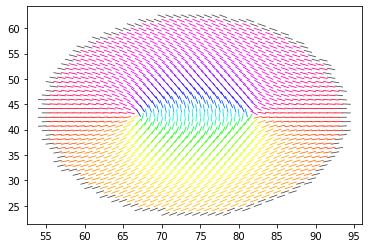

In [63]:
fig, ax = plt.subplots()

clist=cm.hsv(thDataB[0,:]/np.pi)
#clist[bindst2]=[(0,0,0,1)]*len(bindst2)
clist[bindst]=[(0.3,0.3,0.3,1)]*len(bindst)

quiv=ax.quiver(Xt, Yt, np.cos(thDataB[0,:]), np.sin(thDataB[0,:]),
               pivot="mid", scale=40, headlength=0, headwidth=1,
              color=clist,zorder=1)

# ax.scatter(X,Y,c='grey',zorder=0)

#color the intensity of the defect
intensity=ax.tripcolor(Xmesh,Ymesh,fmagMat[:,0],zorder=0,cmap="binary_r")  

points=ax.scatter(Xmesh[sortMat[:2,0]],Ymesh[sortMat[:2,0]],s=500,marker="*",zorder=3,c="red",edgecolor="black",lw=2)

fig.set_figwidth(12)
fig.set_figheight(12)

ax.set_aspect("equal")
ax.axis("off")

#plt.close(fig)

def update_plot(ind):
    U=np.cos(thDataB[ind,:])
    V=np.sin(thDataB[ind,:])
    
    clist=cm.hsv(thDataB[ind,:]/np.pi)
    #clist[bindst2]=[(0,0,0,1)]*len(bindst2)
    clist[bindst]=[(0,0,0,1)]*len(bindst)
    
    intensity.set_array(fmagMat[:,ind])
    
    xpoints=Xmesh[sortMat[:2,ind]]
    ypoints=Ymesh[sortMat[:2,ind]]
    points.set_offsets(np.transpose((xpoints,ypoints)))
    
    quiv.set_color(clist)
    quiv.set_UVC(U,V)
    return quiv, points, intensity

Animate the data as done previously.

In [64]:
datalen=thDataB.shape[0]                      # the number of timesteps taken over the course of the routine

aniTest=ani.FuncAnimation(fig,                # we want to animate the figure
                          update_plot,        # by applying update_plot
                          np.arange(datalen), # at each timestep of thData
                          interval=50,        # this is the delay between frames in ms
                          blit=False)         # an image processing setting

HTML(aniTest.to_html5_video())                # display the animation in the browser

# aniTest.save("test.mp4")                    # save the resulting animation if desired

/home/shae/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


##  Extracting defect locations

Dummy data to extract defect location from.

In [65]:
tdata=thDataB[400,:]

Exponentiate data to sure anti-parallel rods are treated as parallel.

In [66]:
expdata=np.exp(2j*tdata)

In [67]:
xvals=np.linspace(min(Xt),max(Xt),50)   # make resolution finer without changing sites
yvals=np.linspace(min(Yt),max(Yt),50)
Xmesh,Ymesh=np.meshgrid(xvals,yvals)
Xmesh=Xmesh.flatten()
Ymesh=Ymesh.flatten()
Xmesh=Xt
Ymesh=Yt

Define a size for the Gaussian.

In [70]:
sigma=3.0
dx=np.add.outer(Xmesh,-Xt)                # we want a matrix for our Gaussian distribution
dy=np.add.outer(Ymesh,-Yt)                # the mesh values are what we're summing over, the Xt are the values where theta can actually be measured
gmat=np.exp(-(dx**2+dy**2)/(2*sigma**2))  # unnormalized Gaussian matrix
Norm=gmat.sum(axis=1)                     # normalize the Gaussian over the rows since we will sum over rows using expdata

fav=(1/Norm)*gmat.dot(expdata)            # convolve the exponeniated data with the Gaussian and normalize, coarse grained order parameter
fmag=np.abs(fav)                          # we want the min of this that aren't near each other

In [71]:
expDataB=np.exp(2j*thDataB)
f1=gmat.dot(expDataB.transpose())/Norm[:,None]
fmagMat=np.abs(f1)
sortMat=np.argsort(fmagMat,axis=0)

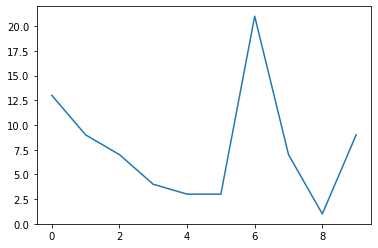

In [72]:
####
magsort=np.argsort(fmag)
amin=np.argmin(fmag)   # one of the mins

Xsort=Xmesh[magsort]
Ysort=Ymesh[magsort]

Rsort=np.diff(Xsort)**2+np.diff(Ysort)**2
plt.plot(Rsort[:10])

Plot it.

(52.525, 95.975, 21.434128743664854, 64.30238623099456)

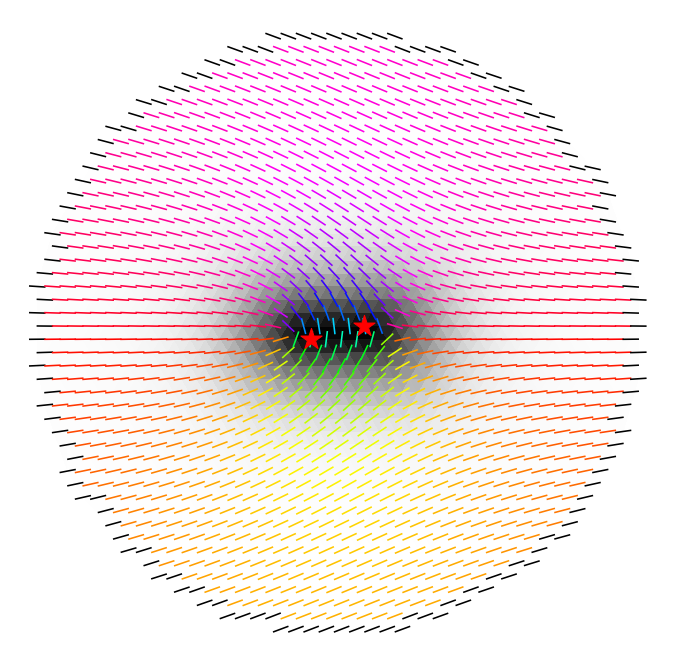

In [73]:
fig, ax = plt.subplots()

clist=cm.hsv(tdata/np.pi)
#clist[bindst2]=[(0,0,0,1)]*len(bindst2)
clist[bindst]=[(0,0,0,1)]*len(bindst)

quiv=ax.quiver(Xt, Yt, np.cos(tdata), np.sin(tdata),
               pivot="mid", scale=40, headlength=0, headwidth=1,
              color=clist,zorder=1)

#color the intensity of the defect
ax.tripcolor(Xmesh,Ymesh,fmagMat[:,400],zorder=0,cmap="binary_r")  

ax.scatter(Xmesh[sortMat[:2,400]],Ymesh[sortMat[:2,400]],s=500,marker="*",zorder=3,c="red")

#ax.scatter(Xmesh,Ymesh,s=10,zorder=1)

fig.set_figwidth(12)
fig.set_figheight(12)

ax.set_aspect("equal")
ax.axis("off")